In [91]:
!ls ../data
!mkdir -p ../assets/

ptb.char.test.txt   ptb.char.valid.txt  ptb.test.txt   ptb.valid.txt
ptb.char.train.txt  ptbdataset.zip      ptb.train.txt  README


## Folders and imports

In [92]:
DATASET_FOLDER = '../data'
TRAIN_DATASET = f'{DATASET_FOLDER}/ptb.train.txt'
VAL_DATASET = f'{DATASET_FOLDER}/ptb.valid.txt'
TEST_DATASET = f'{DATASET_FOLDER}/ptb.test.txt'

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import List, Any, Dict
from collections import Counter, OrderedDict
from IPython.display import display, Markdown, Latex

## Dataset class

In [94]:
def flatten(lists: List[List[Any]]) -> List[Any]:
    result = []
    for sublist in lists:
        result.extend(sublist)
    return result

class Dataset():
    def __init__(self, filename: str):
        self.filename = filename
        self.sentences = self.load_dataset(filename)
        self.words = flatten(list(map(lambda sent: sent.split(), self.sentences)))
        self.vocabulary = set(self.words)
        
    def load_dataset(self, filename: str):
        return [line for line in open(filename)]
    
    def vocabulary_density(self, embedding: Dict[int, str]):
        count = np.zeros(len(embedding))
        for w in self.words:
            count[embedding[w]] += 1
        return count

In [95]:
train_df = Dataset(TRAIN_DATASET)
val_df = Dataset(VAL_DATASET)
test_df = Dataset(TEST_DATASET)

## Split ratio

In [96]:
analysis = []
total_sentences = 0
total_words = 0
for split in [train_df, val_df, test_df]:
    analysis.append([len(split.sentences), len(split.words), 0, 0])
    total_sentences += len(split.sentences)
    total_words += len(split.words)
for i in range(len(analysis)):
    analysis[i][2] = (analysis[i][0] / total_sentences) * 100
    analysis[i][3] = (analysis[i][1] / total_words) * 100
analysis = pd.DataFrame(
    analysis,
    columns=['Sentences', 'Words', 'Sentences split ratio', 'Words split ratio'],
    index=['Train', 'Validation', 'Test']
)

In [97]:
analysis

,Sentences,Words,Sentences split ratio,Words split ratio
Train,42068,887521,85.505803,85.620116
Validation,3370,70390,6.849733,6.790600
Test,3761,78669,7.644464,7.589284


In [98]:
analysis.Sentences.sum(), analysis.Words.sum()

(49199, 1036580)

## Vocabularies distribution

In [51]:
total_vocabulary = (train_df.vocabulary.union(val_df.vocabulary)).union(test_df.vocabulary)
int_embedding = {v: i for i, v in enumerate(total_vocabulary)}
train_density = train_df.vocabulary_density(int_embedding)
val_density = val_df.vocabulary_density(int_embedding)
test_density = test_df.vocabulary_density(int_embedding)
analysis = []
for word, idx in int_embedding.items():
    analysis.append([word, int(train_density[idx]), int(val_density[idx]), int(test_density[idx])])
    
analysis = pd.DataFrame(analysis, columns=[
    'Word',
    'Train count',
    'Validation count',
    'Test count'
]).set_index('Word')

In [52]:
analysis

,Train count,Validation count,Test count
Word,,,
publishing,64,4,6
hitachi,18,0,0
dictaphone,3,8,0
squeeze,24,2,4
equation,4,2,0
...,...,...,...
supplied,8,2,6
approves,7,0,0
truth,20,1,0


Words only in train

In [53]:
analysis[
    (analysis['Train count'] >= 0)
    & (analysis['Validation count'] == 0)
    & (analysis['Test count'] == 0)]

,Train count,Validation count,Test count
Word,,,
hitachi,18,0,0
confronted,6,0,0
proving,13,0,0
nixon,36,0,0
roberti,6,0,0
...,...,...,...
espectador,7,0,0
contemplated,6,0,0
carolinas,6,0,0


Words only in validation

In [54]:
analysis[
    (analysis['Train count'] == 0)
    & (analysis['Validation count'] > 0)
    & (analysis['Test count'] == 0)]

,Train count,Validation count,Test count
Word,,,


Words only in test

In [55]:
analysis[
    (analysis['Train count'] == 0)
    & (analysis['Validation count'] == 0)
    & (analysis['Test count'] > 0)]

,Train count,Validation count,Test count
Word,,,


/tmp/ipykernel_54754/2182263228.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('../assets/words_distribution.pdf')
/tmp/ipykernel_54754/2182263228.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('../assets/words_distribution.pdf')
/nix/store/ik2k5zq27xakwcv7ldda7nblz6y23lnv-python3-3.9.9-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


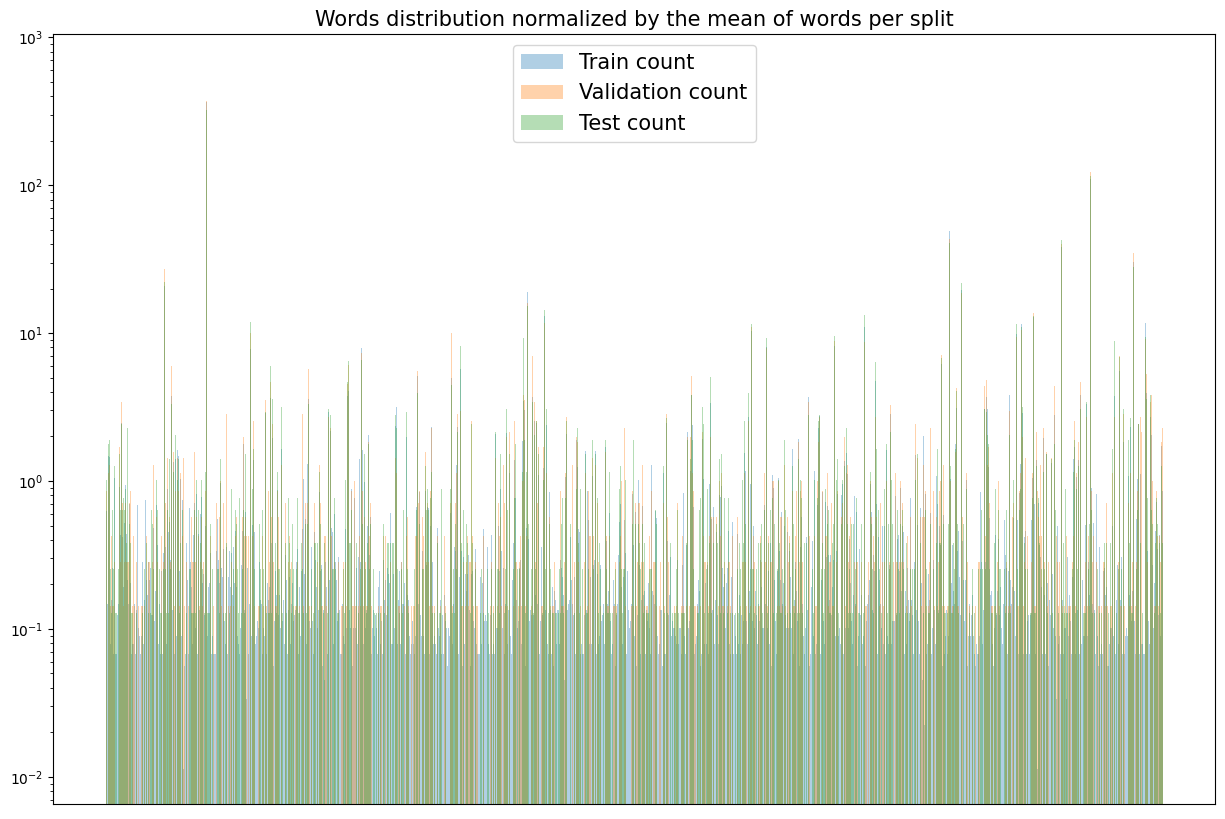

In [56]:
plt.rc('legend',fontsize=15)
plt.figure(figsize=(15,10))
for split in ['Train count', 'Validation count', 'Test count']:
    plt.hist(
        analysis.index.values,
        len(analysis),
        weights=analysis[split] / analysis[split].mean(),
        label=split,
        alpha=0.35
    )
plt.xticks(rotation=45)
plt.yscale("log")
plt.xticks([])
plt.title('Words distribution normalized by the mean of words per split', fontsize=15)
plt.legend()
plt.savefig('../assets/words_distribution.pdf')
plt.show()

In [57]:
table =  "| Words most frequent | Train word - count | Validation word - count | Test word - count |\n"
table += "|---------------------|-------------------:|------------------------:|------------------:|\n"
train = analysis.sort_values('Train count', ascending=False)
validation = analysis.sort_values('Validation count', ascending=False)
test = analysis.sort_values('Test count', ascending=False)
for i in range(10):
    table += f"| {i + 1} | {train.index[i]} - {train.iloc[i][0]} | {validation.index[i]} - {validation.iloc[i][1]} | {test.index[i]} - {test.iloc[i][2]} |\n"
display(Markdown(table))
table =  "| Words least frequent | Train word - count | Validation word - count | Test word - count |\n"
table += "|---------------------|-------------------:|------------------------:|------------------:|\n"
train = analysis.sort_values('Train count', ascending=True)
validation = analysis.sort_values('Validation count', ascending=True)
validation = validation[validation['Validation count'] != 0]
test = analysis.sort_values('Test count', ascending=True)
test = test[test['Test count'] != 0]
for i in range(10):
    table += f"| {i + 1} | {train.index[i]} - {train.iloc[i][0]} | {validation.index[i]} - {validation.iloc[i][1]} | {test.index[i]} - {test.iloc[i][2]} |\n"
display(Markdown(table))

| Words most frequent | Train word - count | Validation word - count | Test word - count |
|---------------------|-------------------:|------------------------:|------------------:|
| 1 | the - 50770 | the - 4122 | <unk> - 4794 |
| 2 | <unk> - 45020 | <unk> - 3485 | the - 4529 |
| 3 | N - 32481 | N - 2603 | N - 2523 |
| 4 | of - 24400 | of - 1832 | of - 2195 |
| 5 | to - 23638 | to - 1750 | to - 2042 |
| 6 | a - 21196 | a - 1738 | a - 1821 |
| 7 | in - 18000 | in - 1392 | in - 1640 |
| 8 | and - 17474 | and - 1391 | and - 1539 |
| 9 | 's - 9784 | 's - 868 | 's - 903 |
| 10 | that - 8931 | for - 726 | that - 831 |


| Words least frequent | Train word - count | Validation word - count | Test word - count |
|---------------------|-------------------:|------------------------:|------------------:|
| 1 | isi - 1 | okla. - 1 | engine - 1 |
| 2 | daewoo - 1 | tens - 1 | jitters - 1 |
| 3 | mlx - 1 | est - 1 | innocent - 1 |
| 4 | gitano - 1 | population - 1 | reinforce - 1 |
| 5 | centrust - 1 | clinical - 1 | swiss - 1 |
| 6 | memotec - 1 | labels - 1 | replacing - 1 |
| 7 | ipo - 1 | characterized - 1 | execution - 1 |
| 8 | banknote - 1 | byrd - 1 | embassy - 1 |
| 9 | cluett - 1 | loaded - 1 | unveiled - 1 |
| 10 | biscuits - 1 | contested - 1 | tentatively - 1 |


## Sentence lengths

In [99]:
train_lengths = list(map(lambda x: len(x), train_df.sentences))
val_lengths = list(map(lambda x: len(x), val_df.sentences))
test_lengths = list(map(lambda x: len(x), test_df.sentences))

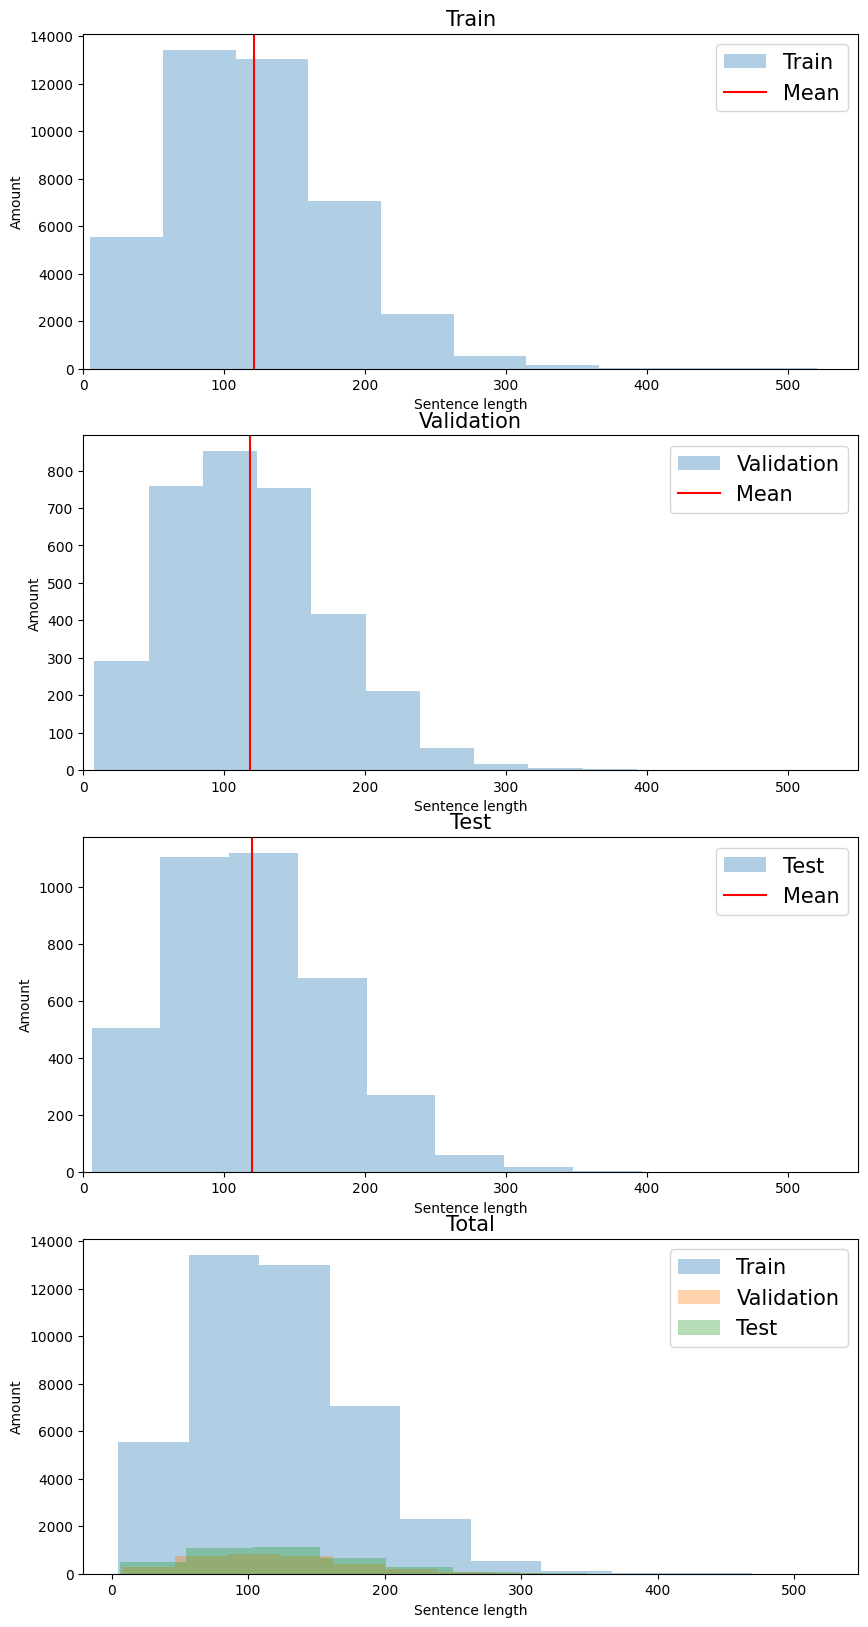

In [100]:
plt.rc('legend',fontsize=15)
fig, axs = plt.subplots(4, figsize=(10,20))
for ax, split, split_name in zip(
    axs[:-1],
    [train_lengths, val_lengths, test_lengths],
    ['Train', 'Validation', 'Test'],
):
    ax.hist(
        split,
        label=split_name,
        alpha=0.35
    )
    ax.axvline(x=sum(split)/len(split), color='red', label='Mean')
    ax.set_title(split_name, fontsize=15)
    ax.set_xlabel("Sentence length")
    ax.set_ylabel("Amount")
    ax.set_xlim([0, 550])
    ax.legend()
    
for split, split_name in zip(
    [train_lengths, val_lengths, test_lengths],
    ['Train', 'Validation', 'Test'],
):
    axs[-1].hist(
        split,
        label=split_name,
        alpha=0.35
    )
    axs[-1].set_title("Total", fontsize=15)
    axs[-1].set_xlabel("Sentence length")
    axs[-1].set_ylabel("Amount")
plt.legend()
plt.savefig('../assets/sentence_lengths_distribution.pdf')
plt.savefig('../assets/sentence_lengths_distribution.png')
plt.show()